In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import CIFAR10, MNIST
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T

In [ ]:
train_set = CIFAR10(root='/', download=True, train=True, transform=T.ToTensor())
train_set, val_set = torch.utils.data.random_split(train_set, [0.8, 0.2])
test_set = CIFAR10(root='/', download=True, train=False, transform=T.ToTensor())

100%|██████████| 170498071/170498071 [00:06<00:00, 28220362.21it/s]


Extracting /cifar-10-python.tar.gz to /
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
# LeNet5
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 32 x 16 x 16
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            # 64 x 8 x 8
            nn.Flatten(),
            nn.Linear(in_features=64*8*8, out_features=1024),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

lr=1e-4
weight_decay=1e-2
num_epochs=50
criterion=nn.CrossEntropyLoss()

transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])



optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
%%time

val_losses = []
train_losses = []

for epoch_num in range(num_epochs):
    model.train()

    epoch_losses = 0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_y_preds = model(batch_x)

        loss = criterion(batch_y_preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses += (len(batch_y)*loss.item())

    epoch_loss = epoch_losses/len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    correctly_labelled = 0
    with torch.no_grad():
        val_epoch_losses = 0
        for val_batch_x, val_batch_y in val_loader:
            val_batch_x = val_batch_x.to(device)
            val_batch_y = val_batch_y.to(device)

            val_batch_y_preds = model(val_batch_x)
            val_loss = criterion(val_batch_y_preds, val_batch_y)
            val_epoch_losses += (len(val_batch_y)*val_loss.item())

            correctly_labelled += (val_batch_y_preds.argmax(dim=1) == val_batch_y).sum().item()

        val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
        val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_num}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')
print('Training Done')



Epoch: 0, train_loss=2.0317899759292604, val_loss=1.827742086982727. labelled 3223/10000 correctly (32.23% accuracy)
Epoch: 1, train_loss=1.767799003791809, val_loss=1.6878123737335204. labelled 3896/10000 correctly (38.96% accuracy)
Epoch: 2, train_loss=1.66527866230011, val_loss=1.62733256149292. labelled 4080/10000 correctly (40.8% accuracy)
Epoch: 3, train_loss=1.6075769088745118, val_loss=1.5586883451461793. labelled 4342/10000 correctly (43.419999999999995% accuracy)
Epoch: 4, train_loss=1.5609769956588746, val_loss=1.545635646057129. labelled 4435/10000 correctly (44.35% accuracy)
Epoch: 5, train_loss=1.5248578666687012, val_loss=1.508217764854431. labelled 4487/10000 correctly (44.87% accuracy)
Epoch: 6, train_loss=1.4835954725265503, val_loss=1.461073310470581. labelled 4695/10000 correctly (46.949999999999996% accuracy)
Epoch: 7, train_loss=1.462047303390503, val_loss=1.4398536884307862. labelled 4809/10000 correctly (48.089999999999996% accuracy)
Epoch: 8, train_loss=1.43009

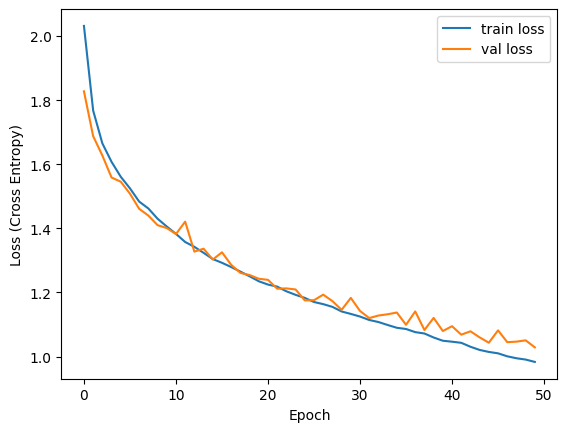

In [ ]:


plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()



In [ ]:
model.eval()
correctly_labelled = 0
with torch.no_grad():
    val_epoch_losses = 0
    for test_batch_x, test_batch_y in test_loader:
        test_batch_x = test_batch_x.to(device)
        test_batch_y = test_batch_y.to(device)

        test_batch_y_preds = model(test_batch_x)
        test_loss = criterion(test_batch_y_preds, test_batch_y)

        correctly_labelled += (test_batch_y_preds.argmax(dim=1) == test_batch_y).sum().item()

    test_epoch_loss = val_epoch_losses/len(test_loader.dataset)
    print(f'Labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


Labelled 6342/10000 correctly (63.42% accuracy)
